In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from CapsuleNet import CapsuleNetwork, CapsuleLoss, display_images
from utils import DICOMCoarseDataset

In [ ]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 50
image_size = 128
classes = ["nodule", "non-nodule"]
train_ratio = 0.8

np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

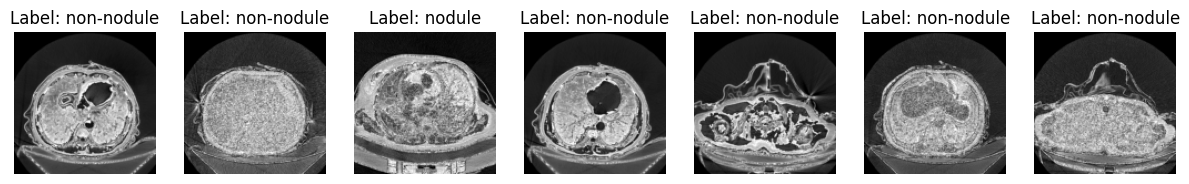

In [ ]:
dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=1000, classes=["nodule", "non-nodule"], transform=transform)
dataset.visualize_images(num_images=7)

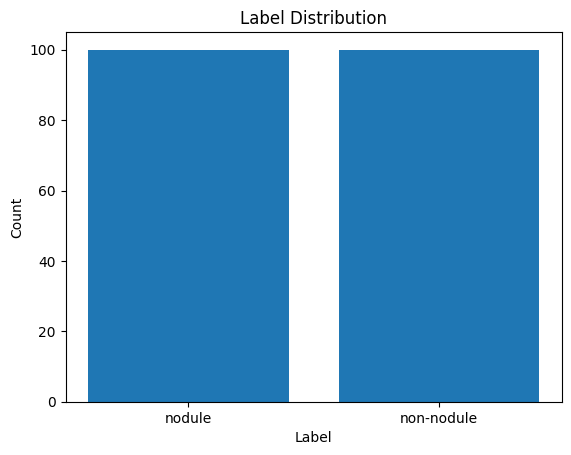

In [5]:
dataset.display_label_distribution()

In [6]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


In [8]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [9]:
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

Epoch: 1 	Training Loss: 17.41292477 	Accuracy: 55.00%
Epoch: 1 	Training Loss: 8.79563522 	Accuracy: 40.00%
Epoch: 1 	Training Loss: 8.49219227 	Accuracy: 50.00%
Epoch: 1 	Training Loss: 7.78602743 	Accuracy: 70.00%
Epoch: 1 	Training Loss: 7.63132858 	Accuracy: 70.00%
Epoch: 1 	Training Loss: 7.25508118 	Accuracy: 50.00%
Epoch: 1 	Training Loss: 6.87992573 	Accuracy: 70.00%
Epoch: 1 	Training Loss: 6.79434586 	Accuracy: 30.00%
Epoch: 1 	Training Loss: 6.18634272 	Accuracy: 40.00%
Epoch: 1 	Training Loss: 5.54996347 	Accuracy: 60.00%
Epoch: 1 	Training Loss: 5.47703648 	Accuracy: 50.00%
Epoch: 1 	Training Loss: 4.92487717 	Accuracy: 50.00%
Epoch: 1 	Training Loss: 4.84184790 	Accuracy: 40.00%
Epoch: 1 	Training Loss: 4.39195633 	Accuracy: 30.00%
Epoch: 1 	Training Loss: 3.92769694 	Accuracy: 60.00%
Epoch: 2 	Training Loss: 7.64290810 	Accuracy: 55.00%
Epoch: 2 	Training Loss: 3.94794464 	Accuracy: 40.00%
Epoch: 2 	Training Loss: 3.56765676 	Accuracy: 60.00%
Epoch: 2 	Training Loss: 3.

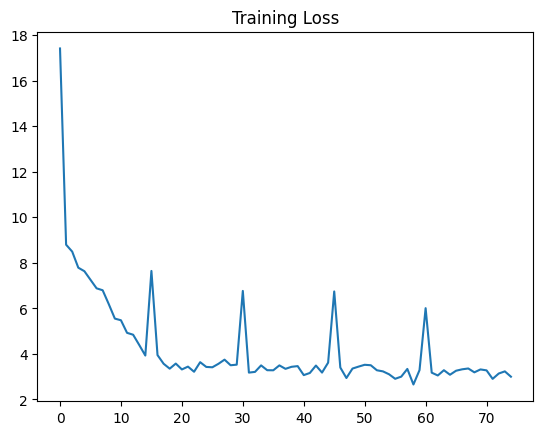

In [10]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

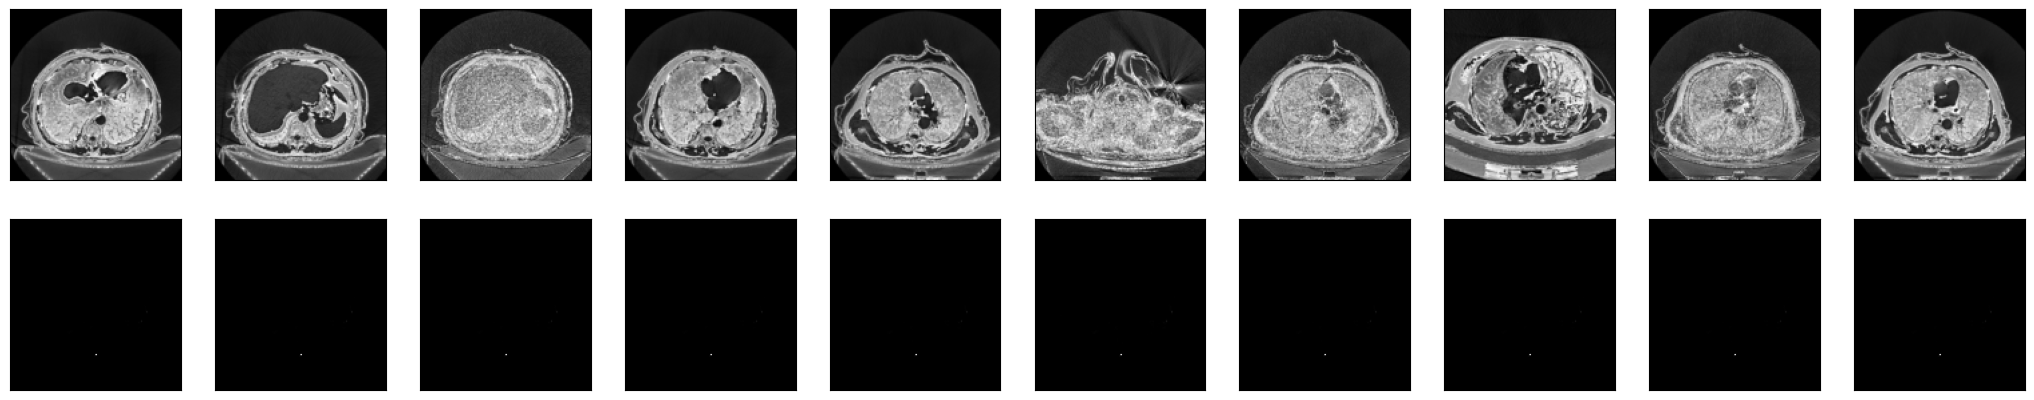

In [11]:
display_images(images, reconstructions)